In [1]:
from shared.preface import *
import shared.functions as fct
import shared.my_units as my
import shared.control_center as CC

## Visualize DM mass distribution

In [ ]:
from swiftsimio import load
from swiftsimio.visualisation.projection import project_pixel_grid
from swiftsimio.visualisation.smoothing_length_generation import generate_smoothing_lengths

data = load('/home/fabian/ownCloud/sim_data/snapshot_0036.hdf5')

# Generate smoothing lengths for the dark matter
data.dark_matter.smoothing_length = generate_smoothing_lengths(
    data.dark_matter.coordinates,
    data.metadata.boxsize,
    kernel_gamma=1.8,
    neighbours=57,
    speedup_fac=2,
    dimension=3,
)

# Project the dark matter mass
dm_mass = project_pixel_grid(
    # Notice here that we pass in the dark matter dataset not the whole
    # data object, to specify what particle type we wish to visualise
    data=data.dark_matter,
    boxsize=data.metadata.boxsize,
    resolution=1024,
    project="masses",
    parallel=True,
    region=None
)

In [ ]:
from matplotlib.pyplot import imsave
from matplotlib.colors import LogNorm

# Everyone knows that dark matter is purple
imsave("sim_data/dm_mass_map.png", LogNorm()(dm_mass), cmap="inferno")

## Calculate halo mass function (HMF)

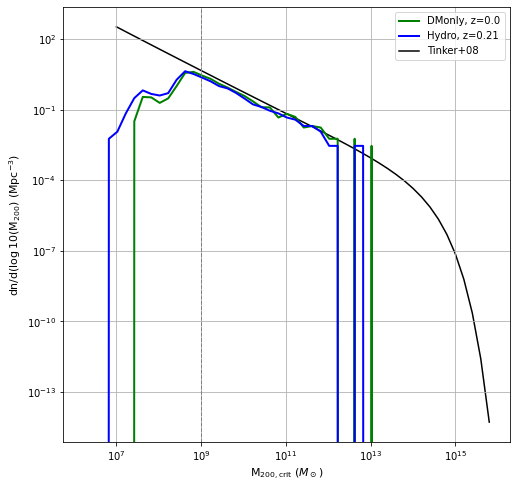

In [3]:
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18');
from colossus.lss import mass_function

def HMF(subhalo_properties, snapshot):

    dlogm = 0.2
    bins = 10 ** (np.arange(6, 15, dlogm))
    V = 12 ** 3 # Mpc

    # Load the data
    g = h5py.File(subhalo_properties, 'r')
    mass = g["Mass_200crit"][:] * 1e10  # convert to Msun

    binnedmass, massrange = np.histogram(mass, bins=bins)

    # Sums all halos with mass greater than a mass of bin range
    massnlarger = np.zeros(len(binnedmass))
    for i in range(0, len(massnlarger)):
        massnlarger[i] = np.sum(binnedmass[i:])

    f = h5py.File(snapshot, 'r')
    cosmo = f["Cosmology"]
    redshift = cosmo.attrs["Redshift"][0]
    mass = f["PartType1/Masses"][:]
    mass = mass[0] * 1e10 # convert to Msun
    limit = 100 * mass

    # --------------------------------------------------------------------------
    ### Determine the HMF

    errormassn = massnlarger ** 0.5
    numbden = massnlarger / V
    numbdenerr = errormassn / V
    massplot = (massrange[:-1] + massrange[1:]) / 2

    # Determine amount of halos in each bin and divide by binsize
    dernumbden = -np.diff(numbden) / np.diff(np.log10(massplot))

    dererr = 2 ** 0.5 / dlogm * (numbdenerr[:-1] + numbdenerr[1:]) / 2

    # To plot amount of halos in each bin, calculate middle of these bins
    M = (massplot[:-1] + massplot[1:]) / 2.
    
    # Renaming
    dndM = dernumbden
    error = dererr
    # --------------------------------------------------------------------------

    return M, dndM, error, limit, redshift


def make_HMF():

    # Different version of L012N0188.

    subhalo_files = [
    '/home/fabian/ownCloud/sim_data/subhalo_0036.properties',  # DMonly
    '/home/fabian/ownCloud/sim_data/subhalo_0033.properties'  # Hydro
    ]

    snapshot_files = [
        '/home/fabian/ownCloud/sim_data/snapshot_0036.hdf5',  # DMonly
        '/home/fabian/ownCloud/sim_data/snapshot_0033.hdf5'  # Hydro
    ]

    plt.figure(figsize=(8,8))

    for sub_f, snap_f in zip(subhalo_files, snapshot_files):

        # Get HMF from sim.
        M, dndM, error, limit, redshift = HMF(sub_f, snap_f)

        redshift = np.round(redshift, 2)

        # Split input string for later use.
        snap = re.split('.hdf5', re.split('/', snap_f)[-1])[0]
        if snap == 'snapshot_0036':
            sim_label = f'DMonly, z={redshift}'
            sim_col = 'green'
        else:
            sim_label = f'Hydro, z={redshift}'
            sim_col = 'blue'        


        # Plot HMF from sim.
        plt.loglog(M, dndM, label=sim_label,lw=2,color=sim_col)
        # plt.fill_between(M, dndM - error, dndM + error, alpha=0.4,color='tab:green')

        h = 0.67
        M = 10 ** np.arange(7, 16, 0.2)

    # Plot HMF from Tinker et al. (2008).
    mfunc = mass_function.massFunction(
        M / h, redshift, mdef='200c', model='tinker08', q_out='dndlnM'
        )
    plt.loglog(M, mfunc / h**3, '-', label='Tinker+08', color='black', zorder=1)


    # Halos with DM particles below limit (100) are numerically unreliable.
    plt.axvline(x=limit, linestyle="--", lw=1, color="grey")

    plt.xlabel("M${}_{200,\mathrm{crit}}$ ($M_\odot$)")
    plt.ylabel("dn/d($\log$10(M${}_{200}$) (Mpc$^{-3}$)")
    plt.legend(loc='upper right' ,prop={'size': 10})
    plt.grid("True")
    plt.savefig(f'sim_data/HMFs_L012N0188.pdf', bbox_inches='tight')#, dpi=200)
    plt.show()


make_HMF()

## Calculate DM density profile of largest halo

In [10]:
from shared.preface import *
import shared.my_units as my
import shared.functions as fct
import shared.control_center as CC
import scipy.stats as stat


def bin_volumes(radial_bins):
    """Returns the volumes of the bins. """

    single_vol = lambda x: (4.0 / 3.0) * np.pi * x ** 3
    outer = single_vol(radial_bins[1:])
    inner = single_vol(radial_bins[:-1])
    return outer - inner


def bin_centers(radial_bins):
    """Returns the centers of the bins. """

    outer = radial_bins[1:]
    inner = radial_bins[:-1]
    return 0.5 * (outer + inner)


def analyse_halo(mass, pos):
    # Define radial bins [log scale, kpc units]
    radial_bins = np.arange(0, 5, 0.1)
    radial_bins = 10 ** radial_bins

    # Radial coordinates [kpc units]
    r = np.sqrt(np.sum(pos ** 2, axis=1))

    SumMasses, _, _ = stat.binned_statistic(x=r, values=np.ones(len(r)) * mass[0], statistic="sum", bins=radial_bins, )
    density = (SumMasses / bin_volumes(radial_bins))  # Msun/kpc^3
    return density


def read_data(which_halos,name,mass_select):

    radial_bins = np.arange(0, 5, 0.1)
    radial_bins = 10**radial_bins
    centers = bin_centers(radial_bins) #kpc

    snaps = h5py.File('/home/fabian/ownCloud/sim_data/snapshot_0036.hdf5')
    group = h5py.File('/home/fabian/ownCloud/sim_data/subhalo_0036.catalog_groups')
    parts = h5py.File('/home/fabian/ownCloud/sim_data/subhalo_0036.catalog_particles')
    props = h5py.File('/home/fabian/ownCloud/sim_data/subhalo_0036.properties')

    a = snaps["/Header"].attrs["Scale-factor"]
    mass = snaps['PartType1/Masses'][:] * 1e10 #Msun
    pos = snaps['PartType1/Coordinates'][:][:] * a


    m200c = props["Mass_200crit"][:] * 1e10
    m200c[m200c == 0] = 1
    m200c = np.log10(m200c)
    CoP = np.zeros((len(m200c), 3))
    CoP[:, 0] = props["Xcminpot"][:]
    CoP[:, 1] = props["Ycminpot"][:]
    CoP[:, 2] = props["Zcminpot"][:]
    subtype = props["Structuretype"][:]

    if mass_select == 10:
        select_halos = np.where((m200c >= 9.8) & (m200c <= 10.2))[0]  # >10 star parts
    if mass_select == 11:
        select_halos = np.where((m200c >= 10.8) & (m200c <= 11.2))[0]  # >10 star parts
    if mass_select == 12:
        select_halos = np.where((m200c >= 11.8) & (m200c <= 12.2))[0]  # >10 star parts

    # Checking sample
    if which_halos == 'subhalos':
        select = np.where(subtype[select_halos] > 10)[0]
        select_halos = select_halos[select]
    else:
        select = np.where(subtype[select_halos] == 10)[0]
        select_halos = select_halos[select]

    if len(select_halos) >= 30:
        select_random = np.random.random_integers(len(select_halos) - 1, size=(30))
        select_halos = select_halos[select_random]


    M200 = np.median(10 ** m200c[select_halos])
    num_halos = len(select_halos)

    density_all = np.zeros((len(centers), num_halos))

    for halo in range(0, num_halos):
        halo_j = select_halos[halo]

        # Grab the start position in the particles file to read from
        halo_start_position = group["Offset"][halo_j]
        halo_end_position = group["Offset"][halo_j + 1]
        particle_ids_in_halo = parts["Particle_IDs"][halo_start_position:halo_end_position]
        particle_ids_from_snapshot = snaps["PartType1/ParticleIDs"][...]

        _, indices_v, indices_p = np.intersect1d(particle_ids_in_halo,
                                                 particle_ids_from_snapshot,
                                                 assume_unique=True,
                                                 return_indices=True, )

        particles_mass = mass[indices_p].copy()
        particles_pos = pos[indices_p, :].copy()
        particles_pos -= CoP[halo_j, :]  # centering
        particles_pos *= 1e3  # kpc
        if len(particles_mass) == 0 :continue
        density_all[:, halo] = analyse_halo(particles_mass, particles_pos)

    densityM = np.median(density_all[:, :], axis=1)
    densityUp = np.percentile(density_all[:, :], 84, axis=1)
    densityLow = np.percentile(density_all[:, :], 16, axis=1)

    # Output final median profile:
    output = np.zeros((len(centers),4))
    output[:,0] = centers
    output[:,1] = densityM
    output[:,2] = densityLow
    output[:,3] = densityUp

    if mass_select == 10:
        if which_halos == 'subhalos':
            np.savetxt(
                f'sim_data/Profile_subhalos_M{mass_select}_{name}.txt',
                 output, fmt="%s"
                )
        else:
            np.savetxt(
                f'sim_data/Profile_halos_M{mass_select}_{name}.txt',
                 output, fmt="%s"
                )
    if mass_select == 11:
        if which_halos == 'subhalos':
            np.savetxt(
                f'sim_data/Profile_subhalos_M{mass_select}_{name}.txt',
                 output, fmt="%s"
                )
        else:
            np.savetxt(
                f'sim_data/Profile_halos_M{mass_select}_{name}.txt',
                 output, fmt="%s"
                )
    if mass_select == 12:
        if which_halos == 'subhalos':
            np.savetxt(
                f'sim_data/Profile_subhalos_M{mass_select}_{name}.txt',
                 output, fmt="%s"
                )
        else:
            np.savetxt(
                f'sim_data/Profile_halos_M{mass_select}_{name}.txt',
                 output, fmt="%s"
                )


name = 'Test'

# mass = 10
# read_data("halos",name,mass)
# read_data("subhalos",name,mass)

mass = 11
read_data("halos",name,mass)
# read_data("subhalos",name,mass)

mass = 12
read_data("halos",name,mass)
# read_data("subhalos",name,mass)

/tmp/ipykernel_152372/2250899420.py:56: RuntimeWarning: invalid value encountered in log10
  m200c = np.log10(m200c)
/tmp/ipykernel_152372/2250899420.py:79: DeprecationWarning: This function is deprecated. Please call randint(1, 36 + 1) instead
  select_random = np.random.random_integers(len(select_halos) - 1, size=(30))


## Plot the density profile

1.05E+07 solMass / kpc3
6.65E+05
2.76E+06
7.04E+06


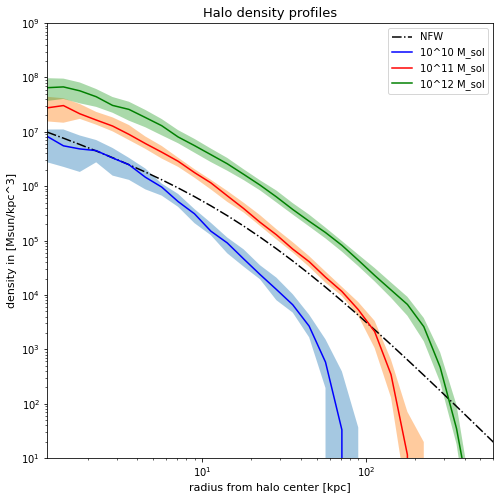

In [44]:
# Get NFW parameters from subhalo_properties.
props = h5py.File('/home/fabian/ownCloud/sim_data/subhalo_0036.properties')
cNFW = props['cNFW_200crit'][:]
rvir = props['R_200crit'][:]
rs = rvir/cNFW * unit.kpc

fig = plt.figure(figsize=(8,8))

ms = [10,11,12]
cs = ['blue', 'red', 'green']
for m, c in zip(ms, cs):
    f = np.loadtxt(f'sim_data/Profile_halos_M{m}_Test.txt')
    r, d, up, low = f[:,0], f[:,1], f[:,2], f[:,3]
    print(f'{np.mean(d):.2E}')

    if m==10:
        rNFW = r*unit.kpc
        rho = np.mean(d)*unit.solMass/unit.kpc**3
        NFW = fct.rho_NFW(rNFW, rho, rs).value
        plt.loglog(rNFW.value, NFW, c='k', ls='-.', label='NFW')
    #     subf = np.loadtxt(f'sim_data/Profile_subhalos_M{m}_Test.txt')
    #     subr, subd, subUp, subLow = subf[:,0], subf[:,1], subf[:,2], subf[:,3]
    #     plt.loglog(subr, subd, label=f'10^{m} M_sol subhalo', ls=':')

    plt.loglog(r, d, c=c, label=f'10^{m} M_sol')
    plt.fill_between(r, up, low, alpha=0.4)


plt.title('Halo density profiles')
plt.xlabel('radius from halo center [kpc]')
plt.ylabel('density in [Msun/kpc^3]')
plt.xlim(np.min(r), 600)
plt.ylim(1e1, 1e9)
plt.legend()
plt.show()